In [88]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'DNN-DIGIST'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [2,3],
    [3,2]
]
RELEASE_FACTOR = 0.1

LR = 0.01
TURNS = 150

K = 3
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

digits = load_digits()

X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size=0.25)
x_train, x_test = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float)
y_train, y_test = torch.tensor(Y_train, dtype=torch.long), torch.tensor(Y_test, dtype=torch.long)

train_Y = y_train.numpy()
test_Y = y_test.numpy()

y_train_onehot = torch.nn.functional.one_hot(y_train)


# ----- Step 3: Create Model Class ----- #

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(64, 32)
        self.l2 = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 64)
        x = F.relu(self.l1(x))
        return self.l2(x)


# ----- Step 4: Instantiate ----- #

model = Net()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
precision_record = []
recall_record = []
F1_record = []
MCC_record = []
AUC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_precision_time = 0
total_recall_time = 0
total_F1_time = 0
total_MCC_time = 0
total_AUC_time = 0
total_Score_time = 0

# Y轴 输出分类结果的模式
# class_list = [item for item in range(OUTPUT_CLASS)]
# class_pattern = list(itertools.permutations(class_list, K))
# class_pattern_len = len(class_pattern)
# print(class_pattern)

# release_matrix = np.ones((len(class_pattern), K))
# # print(release_matrix[0])

# for i in range(len(class_pattern)):
    
#     for single_list in RELEASE_LISTS:
        
#         if set(single_list) <= set(class_pattern[i]) and class_pattern[i][0] in single_list: 
#             for j in range(1, K):
#                 if class_pattern[i][j] in single_list:
#                     release_matrix[i][j] = RELEASE_FACTOR

# for i in range(len(release_matrix)):
#     release_matrix[i][0] = sum(release_matrix[i][1:])
#     release_matrix[i] /= sum(release_matrix[i])
#     print(release_matrix[i])
    
#     if RELEASE_FACTOR in release_matrix[i]:
#         print(class_pattern[i])
#         print(release_matrix[i])            

for turns in range(1, TURNS+1):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)  # criterion
    loss.backward()        # backward and compute gradients
    optimizer.step()       # apply gradients
    
    # Shared Part - train_output
    SP_trainout_time_part_start = time.time()
    train_output = model(x_train)
    SP_trainout_time_part_stop = time.time()
    
    # Shared Part - softmax
    SP_softmax_time_part_start = time.time()
    train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
    SP_softmax_time_part_stop = time.time()
    
    # Shared Part - pred_train_y
    SP_predy_time_part_start = time.time()
    pred_train_y = torch.max(train_output, 1)[1].data.numpy()
    SP_predy_time_part_stop = time.time()
    
    # Acc
    acc_time_part_start = time.time()
    train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
    acc_time_part_stop = time.time()
    
    # MS Loss
    MS_loss_time_part_start = time.time()
    MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
    MS_loss_time_part_stop = time.time()
    
    # CE Loss
    loss_time_part_start = time.time()
    train_loss = loss_fn(train_output, y_train)
    loss_time_part_stop = time.time()
    
    # Precision
    precision_time_part_start = time.time()
    precision = precision_score(train_Y, pred_train_y, average='macro')
    precision_time_part_stop = time.time()
    
    # Recall
    recall_time_part_start = time.time()
    recall = recall_score(train_Y, pred_train_y, average='macro')
    recall_time_part_stop = time.time()
    
    # F1
    F1_time_part_start = time.time()
    F1 = f1_score(train_Y, pred_train_y, average='macro')
    F1_time_part_stop = time.time()
    
    # MCC
    MCC_time_part_start = time.time()
    MCC = matthews_corrcoef(train_Y, pred_train_y)
    MCC_time_part_stop = time.time()
    
    # ROC AUC
    AUC_time_part_start = time.time()
    Y_pred = train_output_result.detach().numpy()
    AUC = roc_auc_score(train_Y, Y_pred, average='macro', multi_class='ovr')
    AUC_time_part_stop = time.time()
    
    # Score
    Score_time_part_start = time.time()
    output_results = train_output_result.detach().numpy()
    prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
#     confidence_pattern =  np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
    confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
    confidence_pattern[confidence_pattern == -1] = 0

    total_score = 0
    pattern_num = len(confidence_pattern)
    release_factors = np.ones((pattern_num, K))
    
    for i in range(pattern_num):
        current_prediction_pattern = list(prediction_pattern[i])
        if train_Y[i] in current_prediction_pattern:
            correct_index = current_prediction_pattern.index(train_Y[i])
            confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
            release_factors[i][correct_index] = K_release
            
            for release_list in RELEASE_LISTS:
                if current_prediction_pattern[correct_index] == release_list[0]:
                    for j in range(K):
                        if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                            release_factors[i][j] = RELEASE_FACTOR
        
    release_factors /= release_factors.sum(axis=1).reshape(-1,1)
    confidence_pattern[confidence_pattern == 0] = 1e-7
    confidence_pattern = -np.log(confidence_pattern / T_max)
    total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
    Score_time_part_stop = time.time()
    
#     for i in range(pattern_num):
# #         release_factors = np.ones(K)
#         if train_Y[i] in prediction_pattern[i]:
#             correct_index = list(prediction_pattern[i]).index(train_Y[i])
# #             correct_index = np.where(prediction_pattern[i] == train_Y[i])
#             confidence_pattern[i][correct_index] = T_MAX - confidence_pattern[i][correct_index]
#             release_factors[i][correct_index] = K-1
            
#             for release_list in RELEASE_LISTS:
#                 if prediction_pattern[i][correct_index] in release_list:
#                     for j in range(K):
#                         if j != correct_index and prediction_pattern[i][j] in release_list:
#                             release_factors[i][j] = RELEASE_FACTOR

#         sorted_states_t[i] /= T
#         confidence_pattern[i] = (confidence_pattern[i] - 1) / T
        
#         print(confidence_pattern)
#         release_factors[i] /= sum(release_factors[i])
#         total_score += sum(np.multiply(release_factors, sorted_states_t[i]))
#         print("++++++++++++++++++++++++")
#         print(sorted_states_index[i])
#         print(sorted_states_t[i])
#         print(train_Y[i])
#         print(release_factors)
#         print(sorted_states_t[i])
    
#     total_score /= len(sorted_states_t)
#     release_factors = normalize(release_factors, axis=1, norm='sum')
#     release_factors = release_factors / release_factors.sum(axis=0)
    
#     print(release_factors.shape)
#     print(release_factors.sum(axis=1).reshape(-1,1).shape)
    
    # (Test Acc)
    test_output = model(x_test)
    pred_test_y = torch.max(test_output, 1)[1].data.numpy()
    test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

    print('Epoch: ', turns, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
          '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
          '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)
#           '| Precision: %.4f' % precision, '| Recall: %.4f' % recall, '| AUC: %.4f' % AUC, 
    
    turns_record.append(turns)
    loss_record.append(train_loss.data.numpy())
    MS_loss_record.append(MS_train_loss.data.numpy())
    train_acc_record.append(train_accuracy)
    precision_record.append(precision)
    recall_record.append(recall)
    F1_record.append(F1)
    MCC_record.append(MCC)
    AUC_record.append(AUC)
    Score_record.append(total_score)
    
    SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
    SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
    SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)
    
    total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
    total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
    total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
    total_precision_time += ((precision_time_part_stop - precision_time_part_start) + SP_predy_time + SP_trainout_time)
    total_recall_time += ((recall_time_part_stop - recall_time_part_start) + SP_predy_time + SP_trainout_time)
    total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
    total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
    total_AUC_time += ((AUC_time_part_stop - AUC_time_part_start) + SP_softmax_time + SP_trainout_time)
    total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))      
#       '\nPrecision: %.8f' % (total_precision_time/TURNS), '\nRecall: %.8f' % (total_recall_time/TURNS), '\nAUC: %.8f' % (total_AUC_time/TURNS)


Net(
  (l1): Linear(in_features=64, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=10, bias=True)
)
Epoch:  1 | Acc: 0.1767 | F1: 0.1221 | MCC: 0.0949 | MS Loss: 0.0935 | CE Loss: 2.4683 | Score: 0.5300 | Test: 0.1822
Epoch:  2 | Acc: 0.1960 | F1: 0.1365 | MCC: 0.1280 | MS Loss: 0.0890 | CE Loss: 2.1563 | Score: 0.6516 | Test: 0.1667
Epoch:  3 | Acc: 0.3430 | F1: 0.3004 | MCC: 0.2909 | MS Loss: 0.0786 | CE Loss: 1.8503 | Score: 0.6327 | Test: 0.3111
Epoch:  4 | Acc: 0.5256 | F1: 0.4690 | MCC: 0.4825 | MS Loss: 0.0681 | CE Loss: 1.5362 | Score: 0.6984 | Test: 0.4978
Epoch:  5 | Acc: 0.6451 | F1: 0.6127 | MCC: 0.6107 | MS Loss: 0.0584 | CE Loss: 1.2756 | Score: 0.7058 | Test: 0.6133
Epoch:  6 | Acc: 0.7157 | F1: 0.6987 | MCC: 0.6896 | MS Loss: 0.0499 | CE Loss: 1.0764 | Score: 0.6159 | Test: 0.7022
Epoch:  7 | Acc: 0.7402 | F1: 0.7270 | MCC: 0.7195 | MS Loss: 0.0435 | CE Loss: 0.9283 | Score: 0.5621 | Test: 0.7244


D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning

Epoch:  8 | Acc: 0.7958 | F1: 0.7901 | MCC: 0.7781 | MS Loss: 0.0363 | CE Loss: 0.7794 | Score: 0.4793 | Test: 0.7622
Epoch:  9 | Acc: 0.8337 | F1: 0.8314 | MCC: 0.8171 | MS Loss: 0.0293 | CE Loss: 0.6441 | Score: 0.3893 | Test: 0.8200
Epoch:  10 | Acc: 0.8582 | F1: 0.8577 | MCC: 0.8428 | MS Loss: 0.0249 | CE Loss: 0.5537 | Score: 0.3337 | Test: 0.8489
Epoch:  11 | Acc: 0.8612 | F1: 0.8600 | MCC: 0.8463 | MS Loss: 0.0226 | CE Loss: 0.4980 | Score: 0.2995 | Test: 0.8644
Epoch:  12 | Acc: 0.8604 | F1: 0.8592 | MCC: 0.8458 | MS Loss: 0.0206 | CE Loss: 0.4490 | Score: 0.2856 | Test: 0.8622
Epoch:  13 | Acc: 0.8857 | F1: 0.8856 | MCC: 0.8735 | MS Loss: 0.0181 | CE Loss: 0.3975 | Score: 0.2598 | Test: 0.8778
Epoch:  14 | Acc: 0.8990 | F1: 0.8999 | MCC: 0.8880 | MS Loss: 0.0161 | CE Loss: 0.3566 | Score: 0.2329 | Test: 0.9044
Epoch:  15 | Acc: 0.9020 | F1: 0.9027 | MCC: 0.8913 | MS Loss: 0.0149 | CE Loss: 0.3323 | Score: 0.2277 | Test: 0.9067
Epoch:  16 | Acc: 0.9087 | F1: 0.9090 | MCC: 0.899

Epoch:  80 | Acc: 0.9948 | F1: 0.9947 | MCC: 0.9942 | MS Loss: 0.0013 | CE Loss: 0.0362 | Score: 0.0266 | Test: 0.9778
Epoch:  81 | Acc: 0.9948 | F1: 0.9947 | MCC: 0.9942 | MS Loss: 0.0013 | CE Loss: 0.0355 | Score: 0.0262 | Test: 0.9778
Epoch:  82 | Acc: 0.9948 | F1: 0.9947 | MCC: 0.9942 | MS Loss: 0.0012 | CE Loss: 0.0348 | Score: 0.0256 | Test: 0.9778
Epoch:  83 | Acc: 0.9955 | F1: 0.9954 | MCC: 0.9951 | MS Loss: 0.0012 | CE Loss: 0.0342 | Score: 0.0251 | Test: 0.9800
Epoch:  84 | Acc: 0.9955 | F1: 0.9954 | MCC: 0.9951 | MS Loss: 0.0012 | CE Loss: 0.0335 | Score: 0.0248 | Test: 0.9800
Epoch:  85 | Acc: 0.9955 | F1: 0.9954 | MCC: 0.9951 | MS Loss: 0.0011 | CE Loss: 0.0329 | Score: 0.0243 | Test: 0.9800
Epoch:  86 | Acc: 0.9963 | F1: 0.9962 | MCC: 0.9959 | MS Loss: 0.0011 | CE Loss: 0.0323 | Score: 0.0240 | Test: 0.9800
Epoch:  87 | Acc: 0.9963 | F1: 0.9962 | MCC: 0.9959 | MS Loss: 0.0011 | CE Loss: 0.0317 | Score: 0.0236 | Test: 0.9800
Epoch:  88 | Acc: 0.9963 | F1: 0.9962 | MCC: 0.9

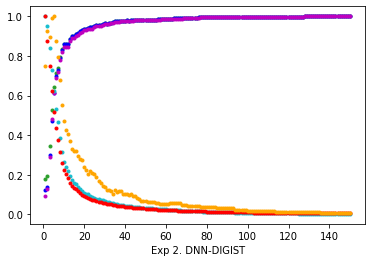

In [92]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_precision = 0
max_recall = 0
max_F1 = 0
max_MCC = 0
max_AUC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
#     if train_acc_record[i] > max_train_acc:
#         max_train_acc = train_acc_record[i]
#     if precision_record[i] > max_precision:
#         max_precision = precision_record[i]
#     if recall_record[i] > max_recall:
#         max_recall = recall_record[i]
#     if F1_record[i] > max_F1:
#         max_F1 = F1_record[i]
#     if AUC_record[i] > max_AUC:
#         max_AUC = AUC_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
#     train_acc_record[i] = train_acc_record[i]/max_train_acc
#     precision_record[i] = precision_record[i]/max_precision
#     recall_record[i] = recall_record[i]/max_recall
#     F1_record[i] = F1_record[i]/max_F1
#     AUC_record[i] = AUC_record[i]/max_AUC
    Score_record[i] = Score_record[i]/max_Score
    

# plt.plot(turns_record, precision_record, '-')
# plt.plot(turns_record, recall_record, '-')
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
# plt.plot(turns_record, AUC_record, '-')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 2'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [95]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()
